## Garbage Image Classification
goal : 
- classify webcam caputured image into one of 12 garbage classes 
- data used for training :
    - 15,150 images in total 
    - 12 different classes of household garbage
    - paper, cardboard, biological, metal, plastic, green-glass, brown-glass, white-glass, clothes, shoes, batteries, and trash 
    - https://www.kaggle.com/mostafaabla/garbage-classification
- model : 
    - transfer learning of pretrained MobileNet deep learning model
- data used for test 
    - webcam image

references : 
- https://www.kaggle.com/mostafaabla/garbage-classification
- https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
- spiced course material

notebook from googlecolab

In [1]:
import glob, random
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.applications import MobileNet
from tensorflow.keras import backend as K
K.clear_session()

In [9]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
# show folders
ls -a /content/drive/MyDrive/garbage_classification/

battery/     brown-glass/  clothes/      metal/  plastic/  trash/
biological/  cardboard/    green-glass/  paper/  shoes/    white-glass/


In [12]:
# list of total image 
img_list =glob.glob('drive/MyDrive/garbage_classification/*/*.jpg')
print(len(img_list))

15555


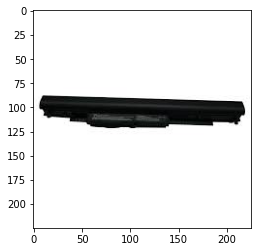

In [14]:
# show a random image
img = load_img(random.sample(img_list,1)[0])
plt.imshow(img)

### ImageDataGenerator : super powerful
- requirements : folders sorted by classes (train and validation can be separated or not)
- capabilities : 
    - deal with problem of small data by manipulating the images (e.g. zoom, translate, rotate, flip etc.)
    - resizing
    - scaling
    - validation split
    - handel the labels
- generate : 
    - train_generator
    - val_generator 
- when fitting : 
    - feed train_generator and val_generator into model.fit_generator

In [16]:
path = 'drive/MyDrive/garbage_classification'
batch_size = 128
targ_size = (224, 224)

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.1)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        path,  # this is the target directory
        target_size=targ_size,  # all images will be resized
        batch_size=batch_size,
        class_mode='categorical',
        subset='training',
        seed=0)  

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        path,
        target_size=targ_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation',
        seed=0)


Found 15555 images belonging to 12 classes.
Found 1549 images belonging to 12 classes.


In [17]:
n_train = 15555
n_val = 1549

In [18]:
train_generator.class_indices

{'battery': 0,
 'biological': 1,
 'brown-glass': 2,
 'cardboard': 3,
 'clothes': 4,
 'green-glass': 5,
 'metal': 6,
 'paper': 7,
 'plastic': 8,
 'shoes': 9,
 'trash': 10,
 'white-glass': 11}

### try using pretrained CNN model

In [19]:
base_model = MobileNet(
    include_top=False, # remove the top dense layers
    input_shape=(224,224,3),
    pooling='avg' # average pooling transforms 4d tensor to 2d feature matrix
    # ^^^ achieves something similar to Flatten()
)

# freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
# add custom layer on top of base model
model.add(Dense(12, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])


17235968/17225924 [==============================] - 0s 0us/step


In [20]:
model.fit_generator(
        train_generator,
        steps_per_epoch=n_train // batch_size,
        epochs=4,
        validation_data=validation_generator,
        validation_steps=n_val // batch_size)
model.save('garbage_model.h5') 

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/4
121/121 [==============================] - 3896s 32s/step - loss: 0.6845 - accuracy: 0.7963 - val_loss: 0.3563 - val_accuracy: 0.8900
Epoch 2/4
121/121 [==============================] - 755s 6s/step - loss: 0.3016 - accuracy: 0.9054 - val_loss: 0.2530 - val_accuracy: 0.9206
Epoch 3/4
121/121 [==============================] - 727s 6s/step - loss: 0.2312 - accuracy: 0.9271 - val_loss: 0.2063 - val_accuracy: 0.9316
Epoch 4/4
121/121 [==============================] - 757s 6s/step - loss: 0.1965 - accuracy: 0.9386 - val_loss: 0.1853 - val_accuracy: 0.9440
